In [1]:
from transformers import pipeline

depth_estimator = pipeline(task="depth-estimation",
                        model="Intel/dpt-hybrid-midas")

/home/saad/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


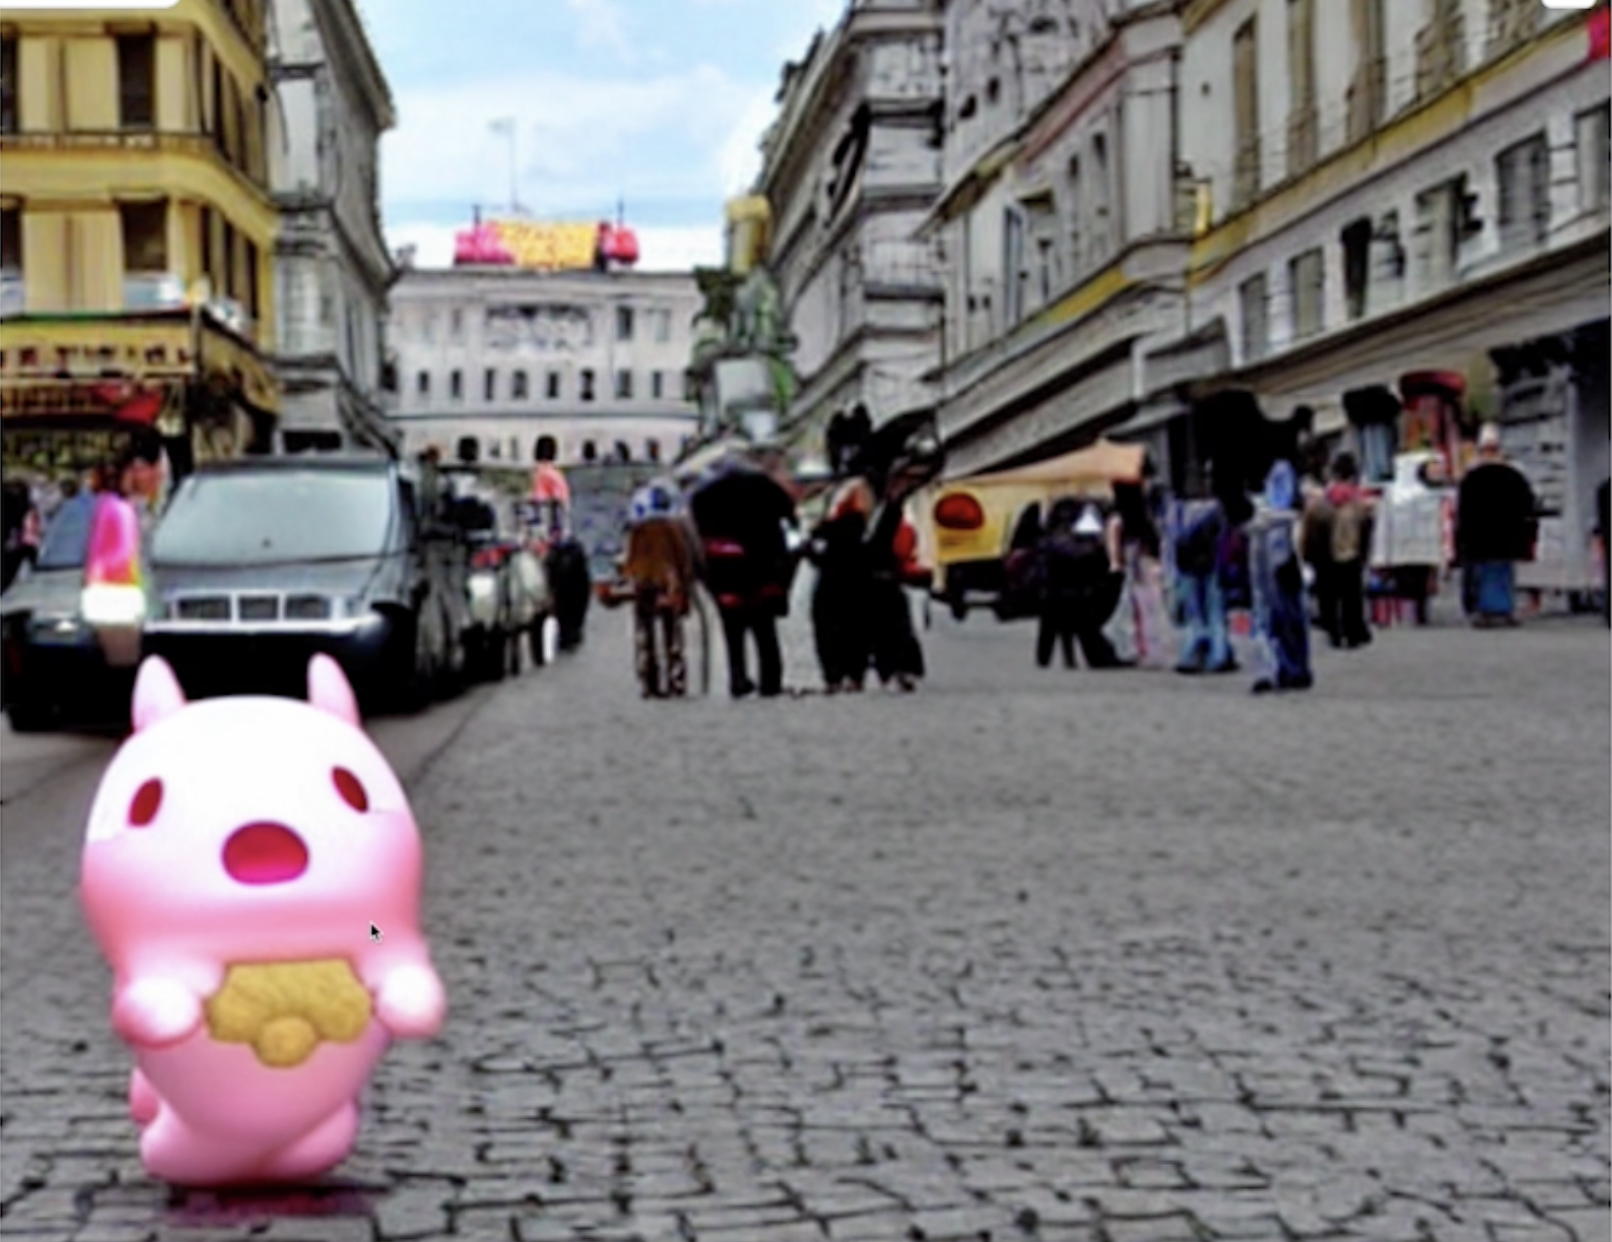

In [2]:
from PIL import Image

raw_image = Image.open("gradio_tamagochi_vienna.png")
raw_image

In [3]:
output = depth_estimator(raw_image)
output

{'predicted_depth': tensor([[[ 248.4070,  252.1829,  256.9170,  ...,  595.8295,  591.8107,
            471.2296],
          [ 247.3371,  254.8536,  257.9679,  ...,  596.0250,  589.0450,
            594.1440],
          [ 259.7674,  259.5481,  261.4167,  ...,  597.6288,  595.3369,
            595.7492],
          ...,
          [3014.1091, 3018.4858, 3019.1724,  ..., 3275.2781, 3269.3467,
           3268.8376],
          [3041.5549, 3040.2786, 3044.4648,  ..., 3280.7483, 3289.3674,
           3274.8713],
          [3039.7500, 3056.0356, 3052.9736,  ..., 3302.0000, 3298.1902,
           3286.9141]]]),
 'depth': <PIL.Image.Image image mode=L size=1612x1242>}

In [4]:
import torch

prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic", #best hyperparameter
    align_corners=False,
)

In [5]:
prediction.shape

torch.Size([1, 1, 1242, 1612])

In [6]:
raw_image.size[::-1]

(1242, 1612)

In [7]:
prediction

tensor([[[[ 248.1577,  248.2614,  248.7576,  ...,  468.0627,  447.0034,
            442.8551],
          [ 248.0309,  248.1445,  248.6918,  ...,  477.7614,  458.3928,
            454.5768],
          [ 247.0835,  247.2386,  247.9993,  ...,  508.8533,  494.9499,
            492.2081],
          ...,
          [3040.0396, 3040.3994, 3042.2332,  ..., 3285.1292, 3283.1472,
           3282.7581],
          [3037.8718, 3038.3882, 3041.0295,  ..., 3288.0654, 3286.3364,
           3285.9919],
          [3037.5522, 3038.1150, 3040.9968,  ..., 3289.0703, 3287.3911,
           3287.0552]]]])

In [8]:
import numpy as np

# unsqueeze adds another dimension to the shape i.e. the number of channels, as interpolate method expects the channel dimension too

output = prediction.squeeze().numpy() #removing the dimension that we added earlier convert to numpy
formatted = (output * 255 / np.max(output)).astype("uint8")  #normalize the tensor and convert it into uint8

depth = Image.fromarray(formatted)

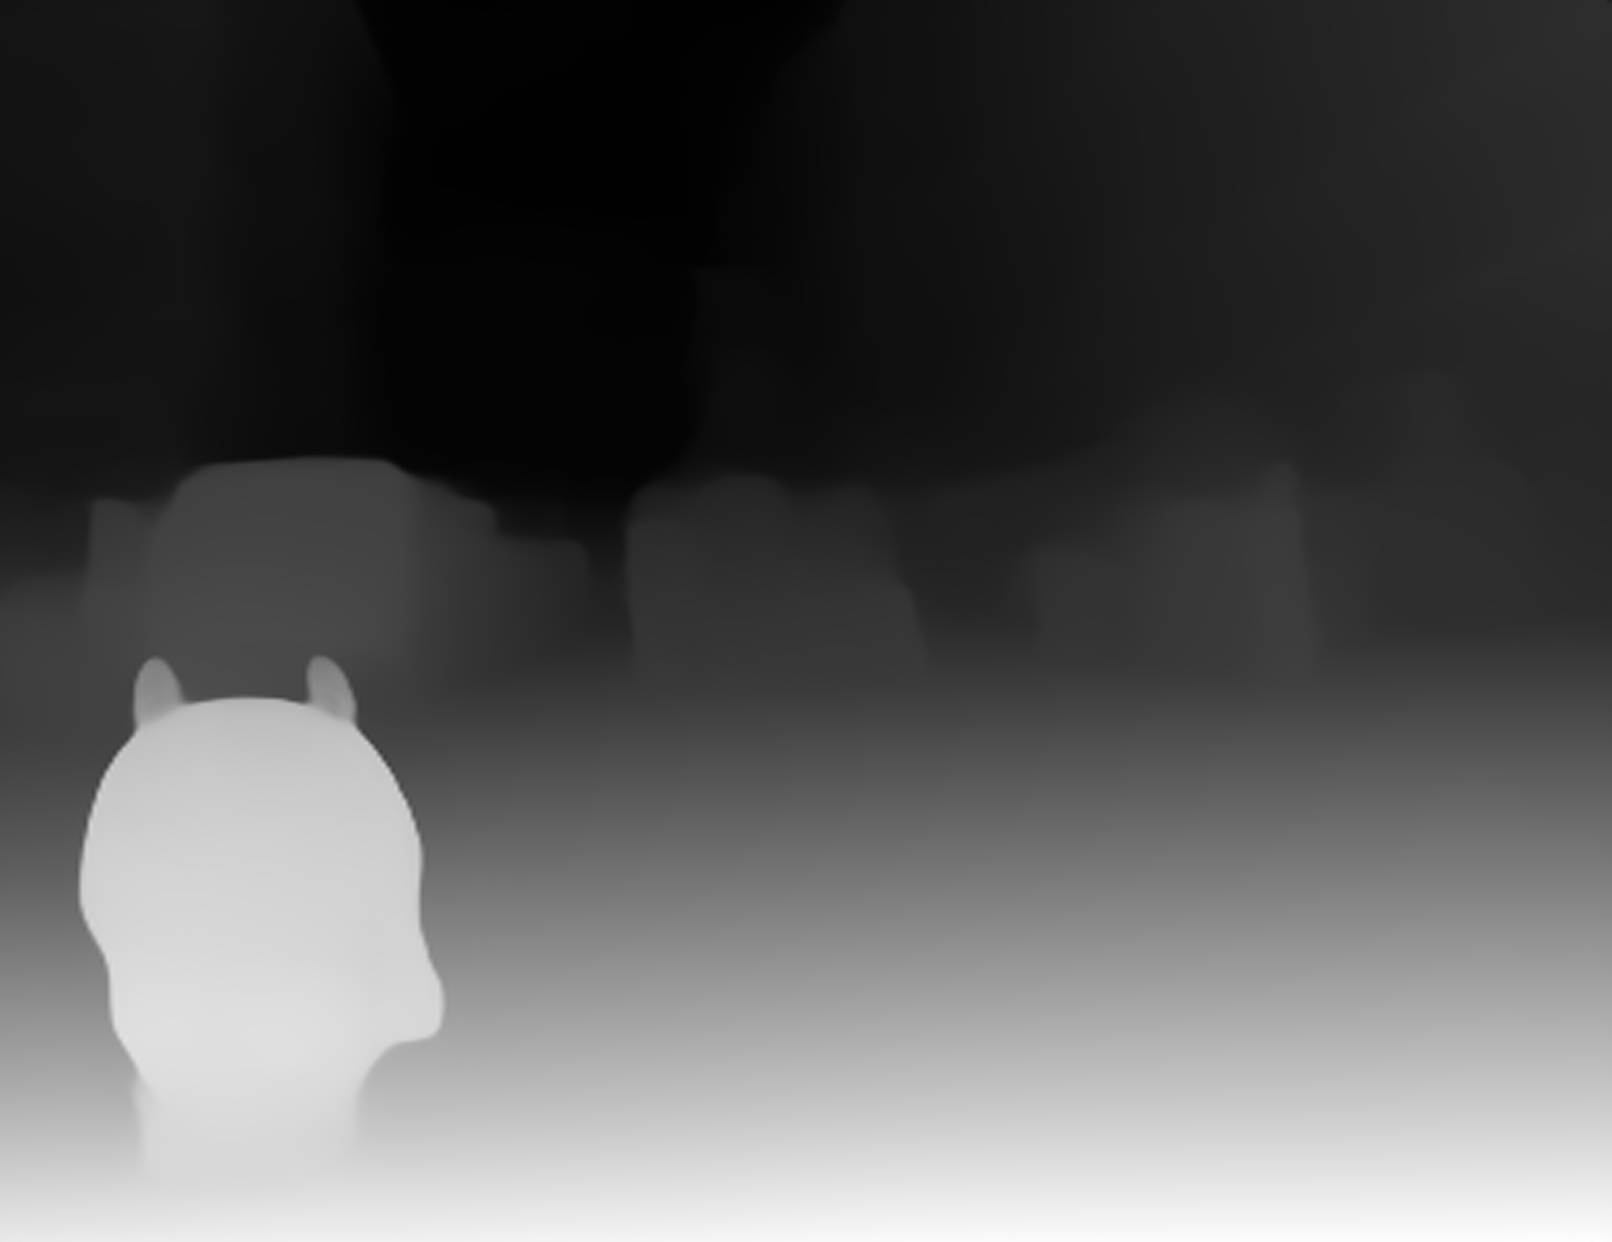

In [9]:
depth

In [11]:
import gradio as gr
from transformers import Pipeline

def launch(input_image):
    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [12]:
iface = gr.Interface(launch, 
                     inputs=gr.Image(type='pil'), 
                     outputs=gr.Image(type='pil'))

In [13]:
iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://3363fb2f348aab3b24.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [14]:
iface.close()

Closing server running on port: 7860
